TODOs
* use contour plot -- DONE
* critical value of recurrent weight . if large enough, the network can hold non zero response after external input goes away -- DONE
* generate moving input -- DONE
* h = v * t (v is speed) -- DONE
* add noise from 2020 bioxiv paper
* feature space with pref stim using linspace(-L, L, N+1)
* critical value of recurrent -- DONE


In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import network_dynamics as ndyn

# Simulation #1 - Fully connected with Gaussian Kernel

We're looking to see that global inhibition is working, that eventually firing rates plateau when there is no longer external input.

[-3.14159265 -3.01336438 -2.88513611 -2.75690784 -2.62867957 -2.5004513
 -2.37222302 -2.24399475 -2.11576648 -1.98753821 -1.85930994 -1.73108167
 -1.60285339 -1.47462512 -1.34639685 -1.21816858 -1.08994031 -0.96171204
 -0.83348377 -0.70525549 -0.57702722 -0.44879895 -0.32057068 -0.19234241
 -0.06411414  0.06411414  0.19234241  0.32057068  0.44879895  0.57702722
  0.70525549  0.83348377  0.96171204  1.08994031  1.21816858  1.34639685
  1.47462512  1.60285339  1.73108167  1.85930994  1.98753821  2.11576648
  2.24399475  2.37222302  2.5004513   2.62867957  2.75690784  2.88513611
  3.01336438  3.14159265]


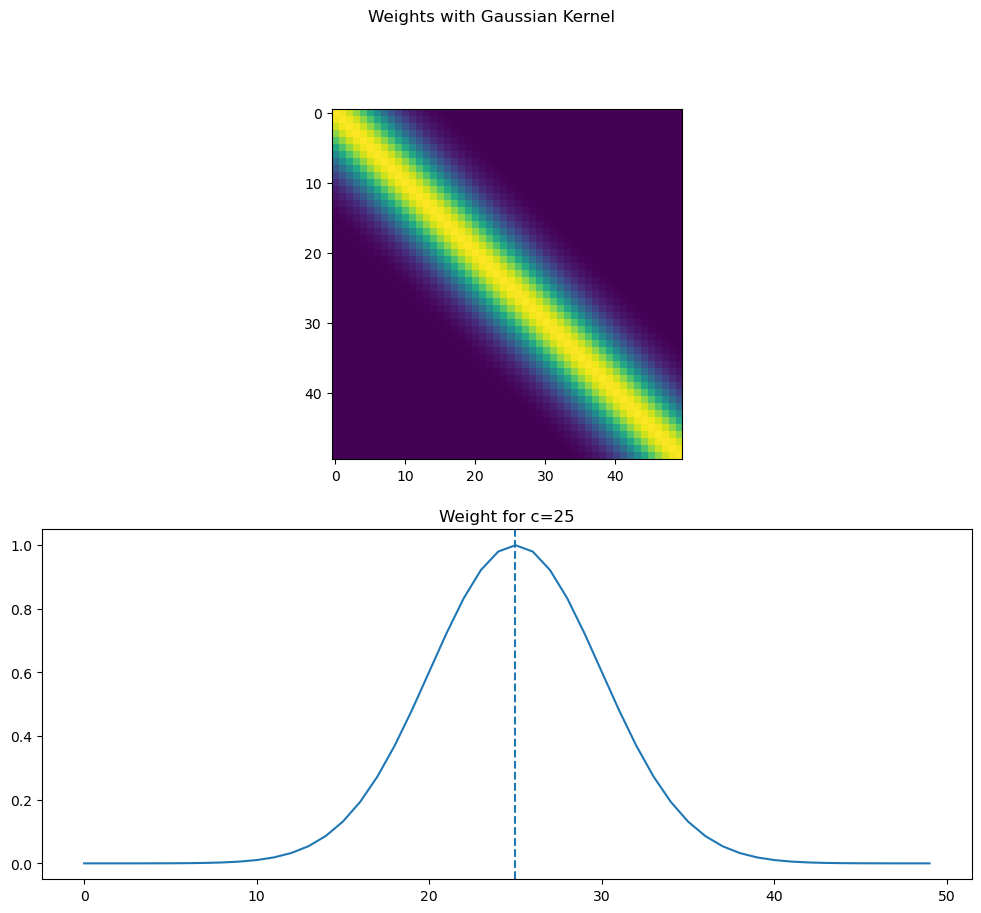

In [32]:
network = ndyn.Network(N=50, T=20, L=np.pi, W_kwargs={'a': np.pi/2})
print(network.prefStim)
ndyn.plot_weight(network, 25, 'Weights with Gaussian Kernel')

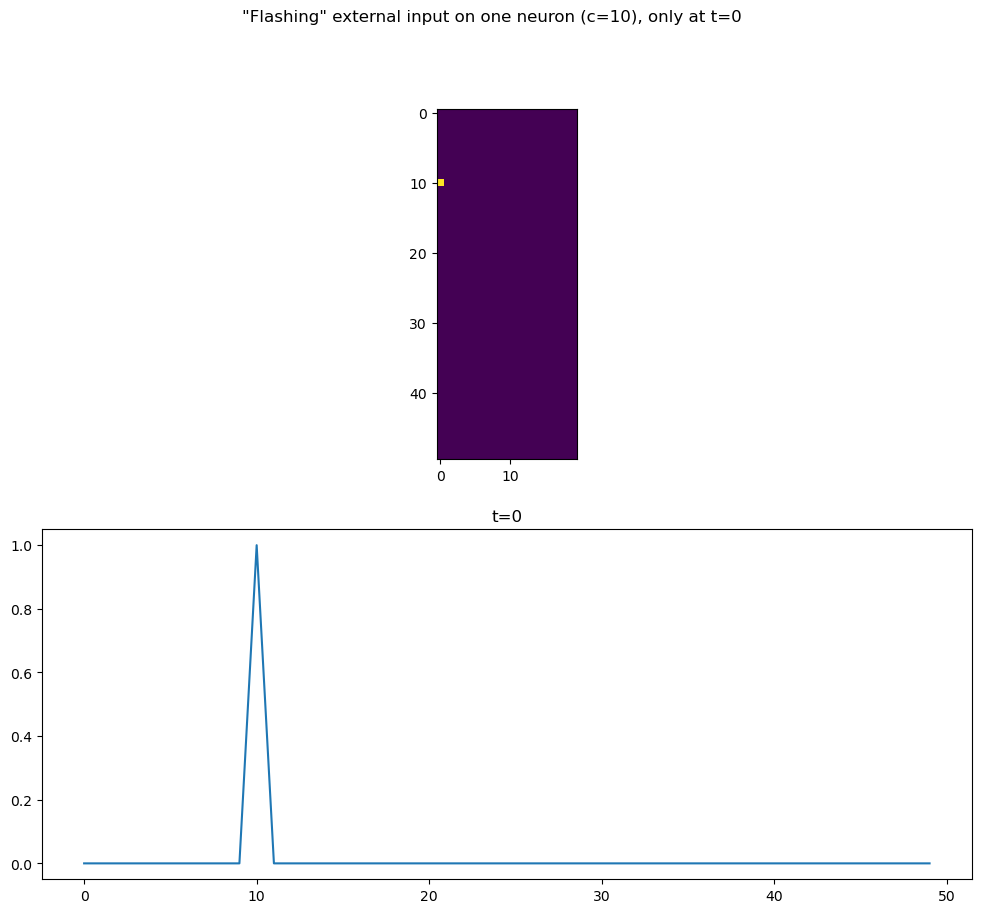

In [33]:
external_input = np.zeros((network.N, network.T))
external_input[10, 0] = 1

ndyn.plot_external_input_at_t(external_input, 0, '"Flashing" external input on one neuron (c=10), only at t=0')

In [34]:
solution = network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
print(solution)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0  1 ... 18 19]
        y: [[ 0.000e+00  1.350e-02 ...  3.554e-06  2.083e-06]
            [ 0.000e+00  1.957e-02 ...  4.426e-06  2.594e-06]
            ...
            [ 0.000e+00  2.569e-11 ...  3.057e-12  1.791e-12]
            [ 0.000e+00  9.266e-12 ...  1.371e-12  8.035e-13]]
      sol: None
 t_events: None
 y_events: None
     nfev: 158
     njev: 0
      nlu: 0


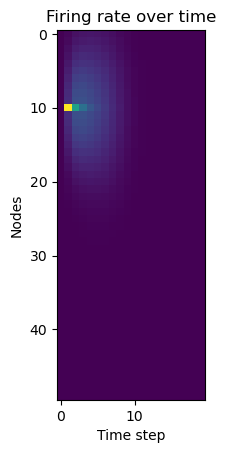

Firing rate diminishes due to global inhibition and a lower recurrent weight


In [35]:
ndyn.plot_firing_rate(network, "Firing rate over time")
print('Firing rate diminishes due to global inhibition and a lower recurrent weight')

# Simulation #2 - "Flashing" external input with strong recurrent weight

We're looking to see that the network maintains the firing rate for a "flashed" input when the recurrent weight is strong.

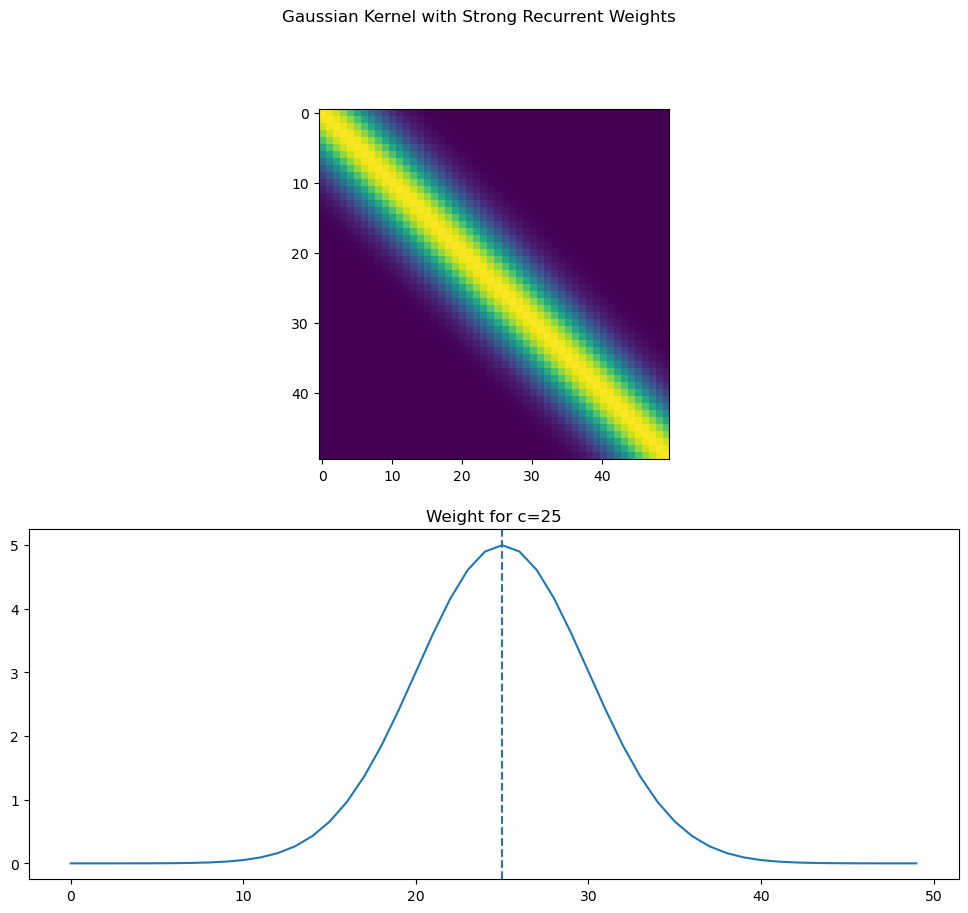

In [36]:
network.W = 5 * ndyn.gaussian_func(ndyn.get_diff_matrix(network), a=np.pi/2)
ndyn.plot_weight(network, 25, 'Gaussian Kernel with Strong Recurrent Weights')

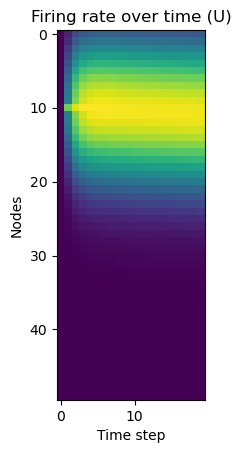

In [37]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)

# Simulation 3 - Constant Stimulus with Gaussian Function

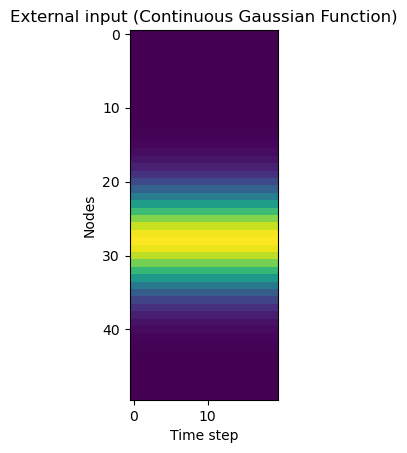

In [38]:
network = ndyn.Network(50, 20)
external_input = ndyn.get_diff_matrix(network, 25)
external_input = ndyn.gaussian_func(external_input)
external_input = np.tile(external_input, (1, network.T))
ndyn.plot_external_input(external_input, 'External input (Continuous Gaussian Function)')

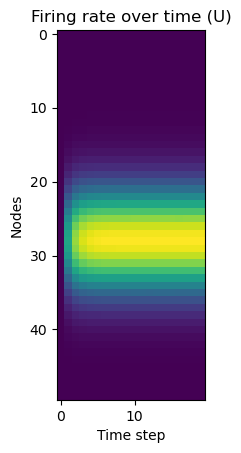

In [39]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)

# Simulation - Periodic Stimulus
"To mimic real situations more precisely, such as when the stimulus is the orientation or moving direction of objects, we restrict the stimulus in the simulation to be a periodical variable. More exactly, we consider stimulus x (and so does the preferred stimulus of neurons) in the range (−π, π ], with x = θ and x = 2π + θ being the same. Under this condition, the steady states of the network will no longer have the exact gaussian form as in equation 2.4. However, provided that the value of a is not too large, say, a < π as considered here, the bell shape of steady states still holds, as confirmed by the simulation. With the periodic condition, the form of recurrent interactions is adjusted..." (Wu & Amari 2005)

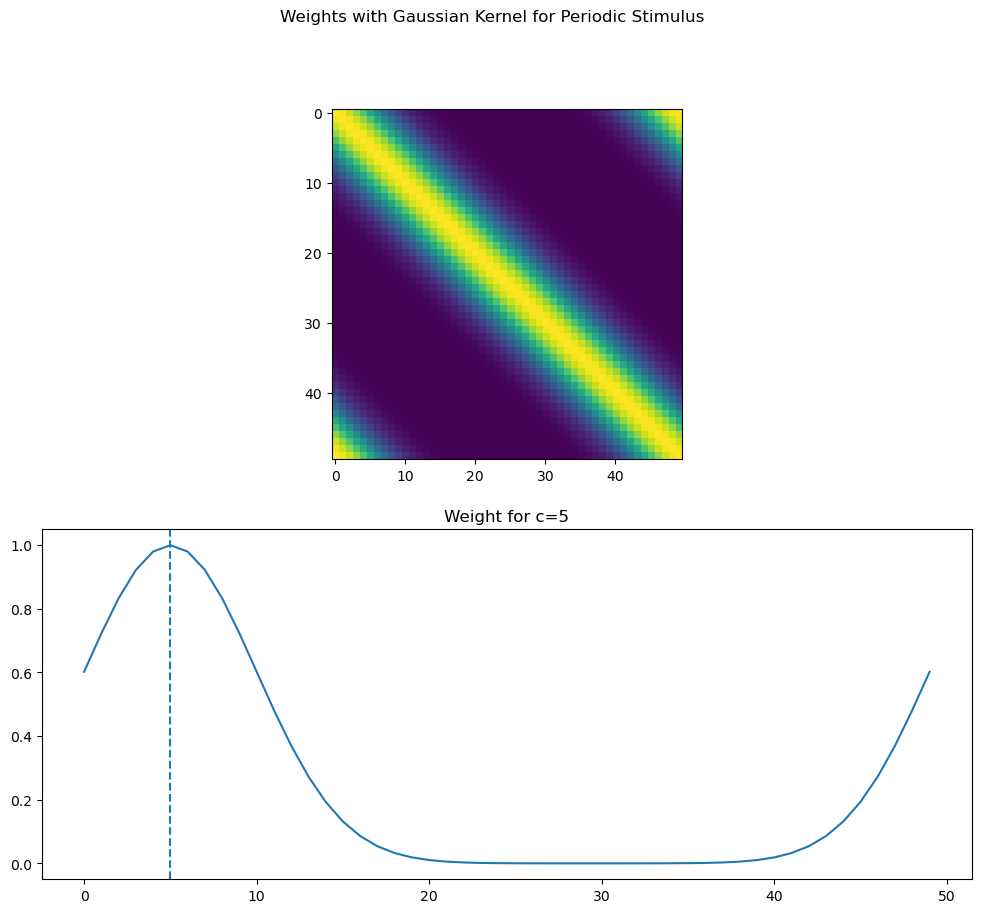

In [40]:
# Weight matrix for periodic stimulus
def diff_matrix_for_periodic_stimulus(nn: ndyn.Network):
    row_indices = nn.prefStim.reshape(-1, 1)
    col_indices = nn.prefStim.reshape(1, -1)
    diff_matrix = np.remainder(np.fabs(col_indices - row_indices) + nn.L, 2 * np.pi) - nn.L

    return diff_matrix

network = ndyn.Network(N=50, T=20, L=np.pi, diff_matrix_func=diff_matrix_for_periodic_stimulus, W_kwargs={'a': np.pi/2})
ndyn.plot_weight(network, 5, 'Weights with Gaussian Kernel for Periodic Stimulus')

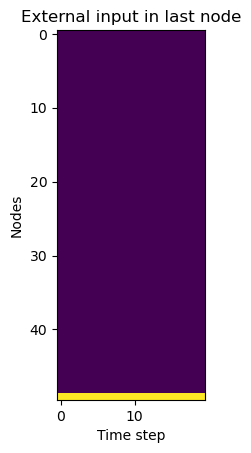

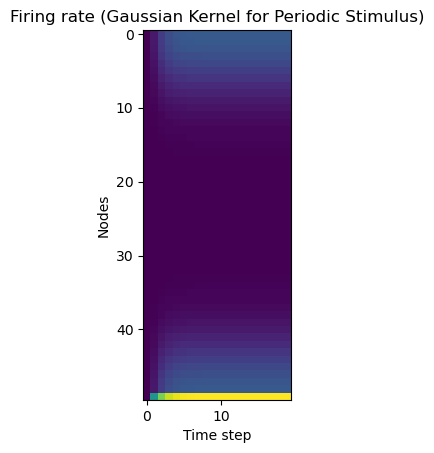

The network whose weights are adjusted for the periodic condition (ring attractor) shows neuronal activity / firing rates "wrapping around" to c=0 when there is activity in the preferred stimulus of c=49.


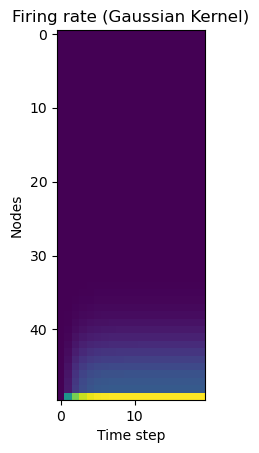

The network which is not adjusted for the periodic condition (line attractor) only shows neuronal activity / firing rates in neighboring neurons c < 49 when there is activity in the preferred stimulus of c=49.


In [41]:
nn_gaussian_kernel = ndyn.Network(N=50, T=20)

external_input = np.zeros((network.N, network.T))
external_input[49] = np.ones(network.T)
ndyn.plot_external_input(external_input, 'External input in last node')
network.simulate(external_input, ivp_func=ndyn.sp_solve_ivp, get_U_func=lambda sol: sol.y)
ndyn.plot_firing_rate(network, 'Firing rate (Gaussian Kernel for Periodic Stimulus)')
print('The network whose weights are adjusted for the periodic condition (ring attractor) shows neuronal activity / firing rates "wrapping around" to c=0 when there is activity in the preferred stimulus of c=49.')
nn_gaussian_kernel.simulate(external_input, ivp_func=ndyn.sp_solve_ivp, get_U_func=lambda sol: sol.y)
ndyn.plot_firing_rate(nn_gaussian_kernel, 'Firing rate (Gaussian Kernel)')
print('The network which is not adjusted for the periodic condition (line attractor) only shows neuronal activity / firing rates in neighboring neurons c < 49 when there is activity in the preferred stimulus of c=49.')

## Moving external input

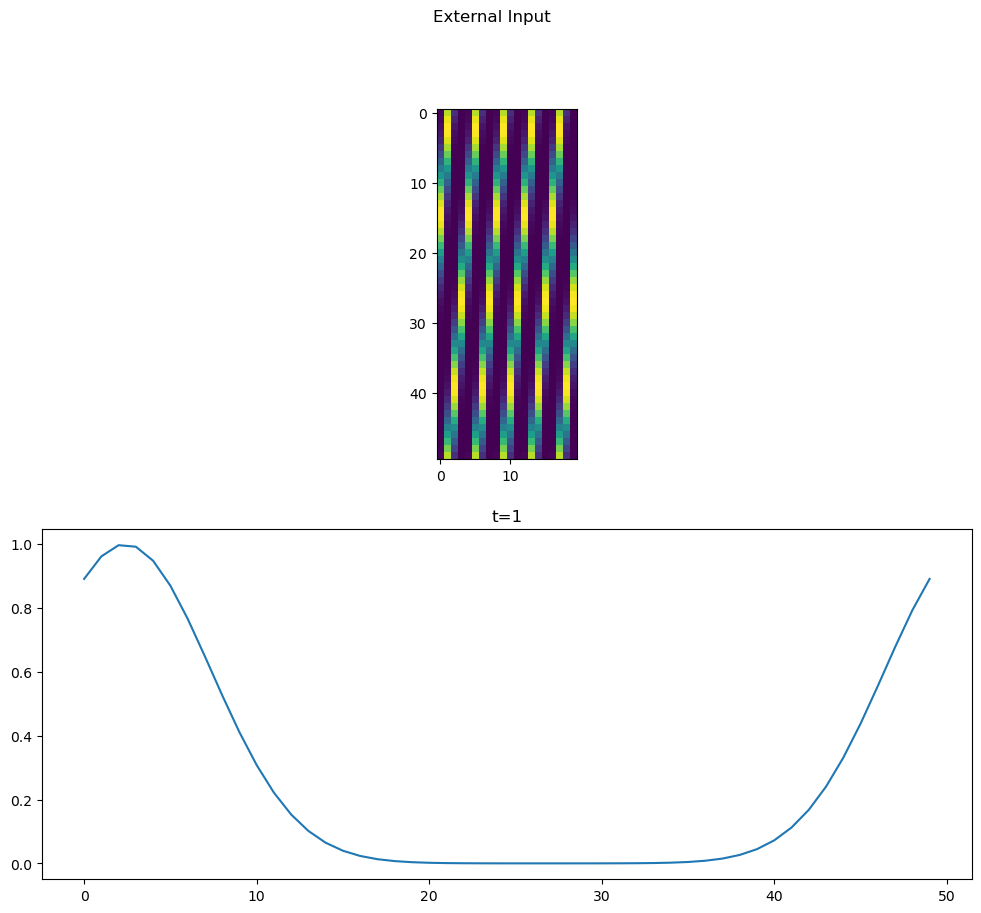

In [42]:
# Moving external input

velocity = np.pi/2
gamma = 1
t = np.tile(np.arange(0, network.T), (network.N, 1))
h = velocity * t
row_indices = network.prefStim.reshape(-1, 1)
row_indices = np.fabs(row_indices - 49) # TODO, c=25 at t=0 is undefined behavior, but it shouldn't be. The gaussian function will diverge
diff_matrix = np.remainder(np.fabs(row_indices - h) + network.L, 2 * np.pi) - network.L
external_input = ndyn.gaussian_func(diff_matrix, a = np.pi / 2)

ndyn.plot_external_input_at_t(external_input, 1)

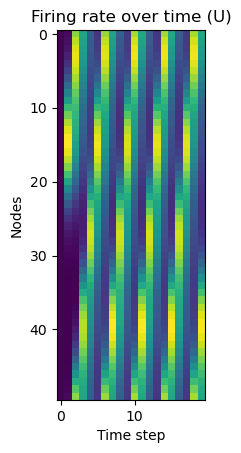

In [43]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)

# Sampling-based Bayesian Inference
Zhang et.al. 2020

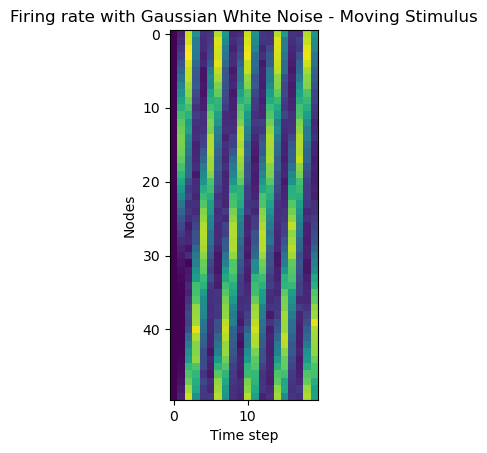

[[  0.          10.16606484 101.51158563  55.60719207  14.95662713
   16.58979761  97.15174742  58.17745578  12.83105572  14.07966004
  100.99010255  56.20299023  17.94772484  15.57780053  97.56916679
   59.45284006  17.07447847  14.99553987  97.28711098  57.12475136]
 [  0.          13.4945328  103.08450132  45.69495355  14.50043523
   19.7330666  104.09390873  52.27101513  14.10899267  19.91440857
  103.95067292  52.42259979  16.52407885  16.42692464 104.93323447
   46.89282662  15.41080275  21.99928576 100.37718381  52.88950275]
 [  0.          17.56657015 109.11185383  45.54834927  14.10705314
   22.93640109 103.09108529  45.40491229  10.28502733  23.21560199
  106.26594204  49.83700545  11.54245642  24.51390319 104.11034387
   46.75810503  12.5400935   18.88857876 105.8489334   50.77943316]
 [  0.          22.42253272 110.44558201  44.5423446   10.23423556
   26.63165631 102.48702371  42.00037956  14.38920399  28.3166153
  108.06032281  40.07335204  15.46861022  31.10425265 103.08

In [230]:
def euler_gwn(u0, T, W, I, gwn, tau=1, rho=10, k=0.001):
    dUdT = np.zeros((u0.shape[0], T))
    dUdT[:, 0] = u0
    for t in range(T - 1):
        u = dUdT[:, t] # (n, 1)
        u[u < 0] = 0
        r = np.power(u, 2) / (1 + k * rho * u.sum()**2) # (n, 1)
        uFano = u.var() / u.mean() if u.mean() != 0 else 0
        dU = (-u + rho * W.T.dot(r) + rho * W.T.dot(I[:, t]) + np.sqrt(tau * uFano) * gwn[:, t]) / tau
        dUdT[:, t + 1] = u + dU
    return dUdT

def euler_ivp_gwn(network, external_input, gwn=None, tau=1, rho=10, k=0.001):
    if gwn is None:
        mu = 1
        sig = 0.5
        gwn = np.random.normal(mu, sig, (sampling_network.N, sampling_network.T))

    return euler_gwn(network.U[:, 0], network.T, network.W, external_input, gwn, tau, rho, k)
    # todo: gwn should be a parameter

sampling_network = ndyn.Network(N=50, T=20, L=np.pi, diff_matrix_func=diff_matrix_for_periodic_stimulus, W_kwargs={'a': np.pi/2})

solution = sampling_network.simulate(external_input, euler_ivp_gwn, lambda sol: sol)
ndyn.plot_firing_rate(sampling_network, 'Firing rate with Gaussian White Noise - Moving Stimulus')
print(solution)

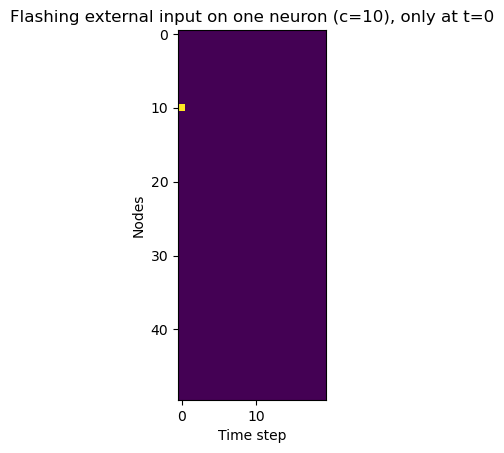

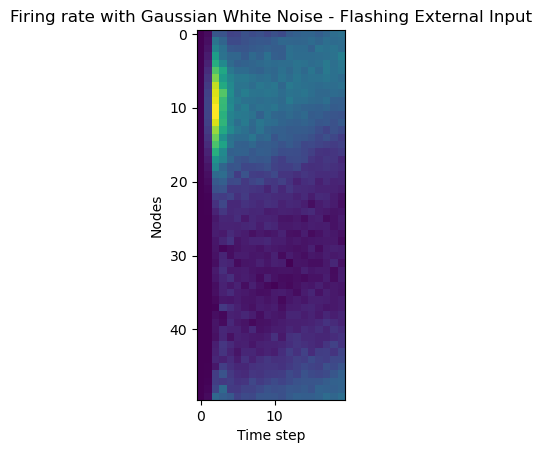

In [231]:
flashing_external_input = np.zeros((sampling_network.N, sampling_network.T))
flashing_external_input[10, 0] = 1
ndyn.plot_external_input(flashing_external_input, 'Flashing external input on one neuron (c=10), only at t=0')
solution = sampling_network.simulate(flashing_external_input, euler_ivp_gwn, lambda sol: sol)
ndyn.plot_firing_rate(sampling_network, 'Firing rate with Gaussian White Noise - Flashing External Input')

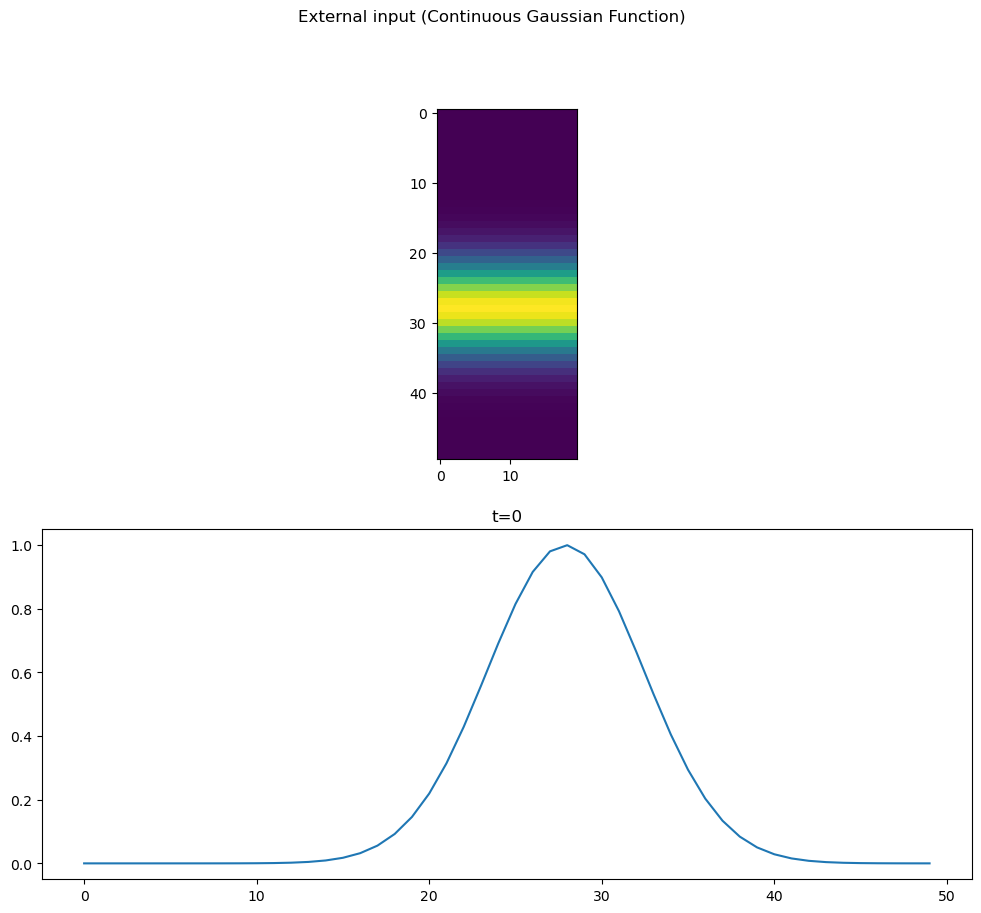

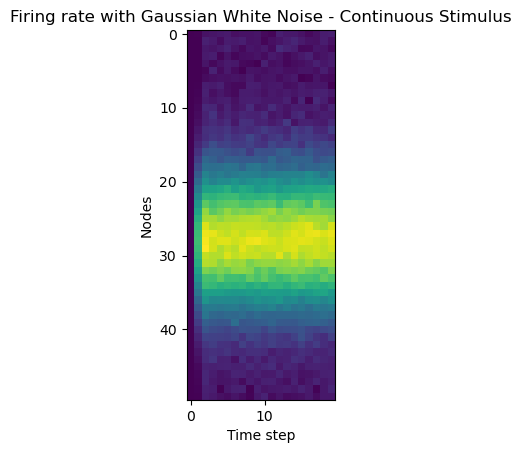

In [232]:
continuous_external_input = ndyn.get_diff_matrix(ndyn.Network(50, 20), 25)
continuous_external_input = ndyn.gaussian_func(continuous_external_input)
continuous_external_input = np.tile(continuous_external_input, (1, network.T))
ndyn.plot_external_input_at_t(continuous_external_input, 0, 'External input (Continuous Gaussian Function)')
solution = sampling_network.simulate(continuous_external_input, euler_ivp_gwn, lambda sol: sol)
ndyn.plot_firing_rate(sampling_network, 'Firing rate with Gaussian White Noise - Continuous Stimulus')

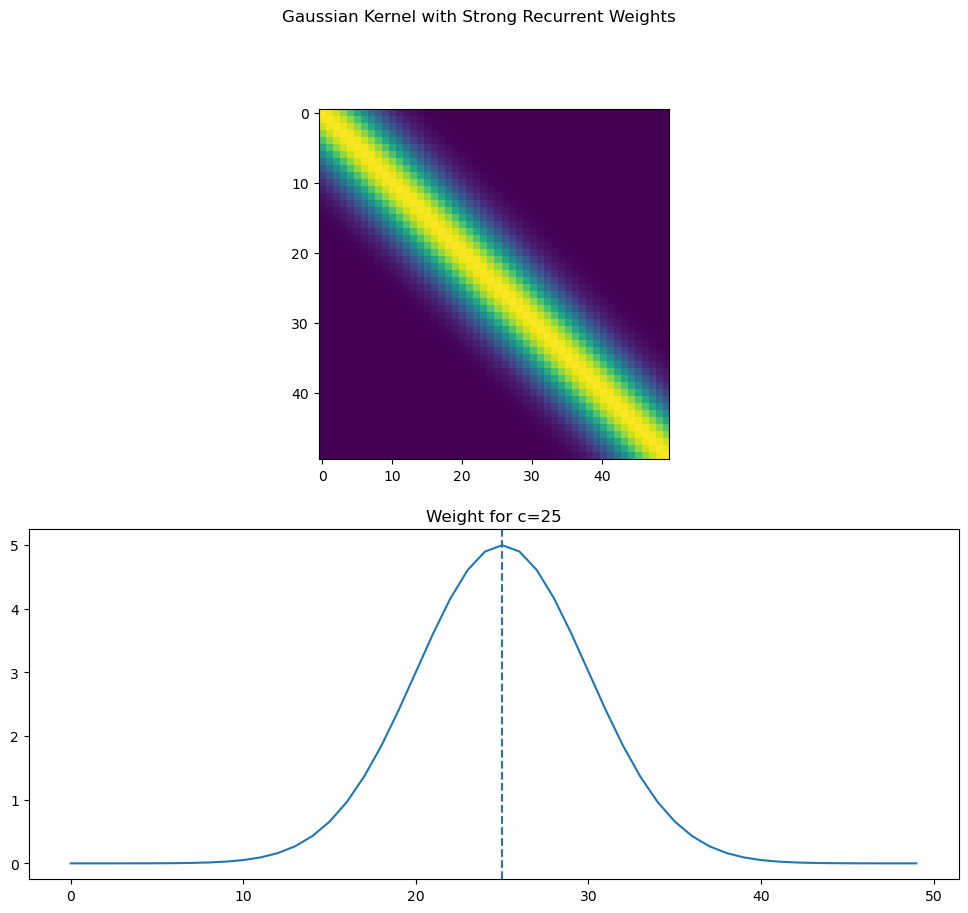

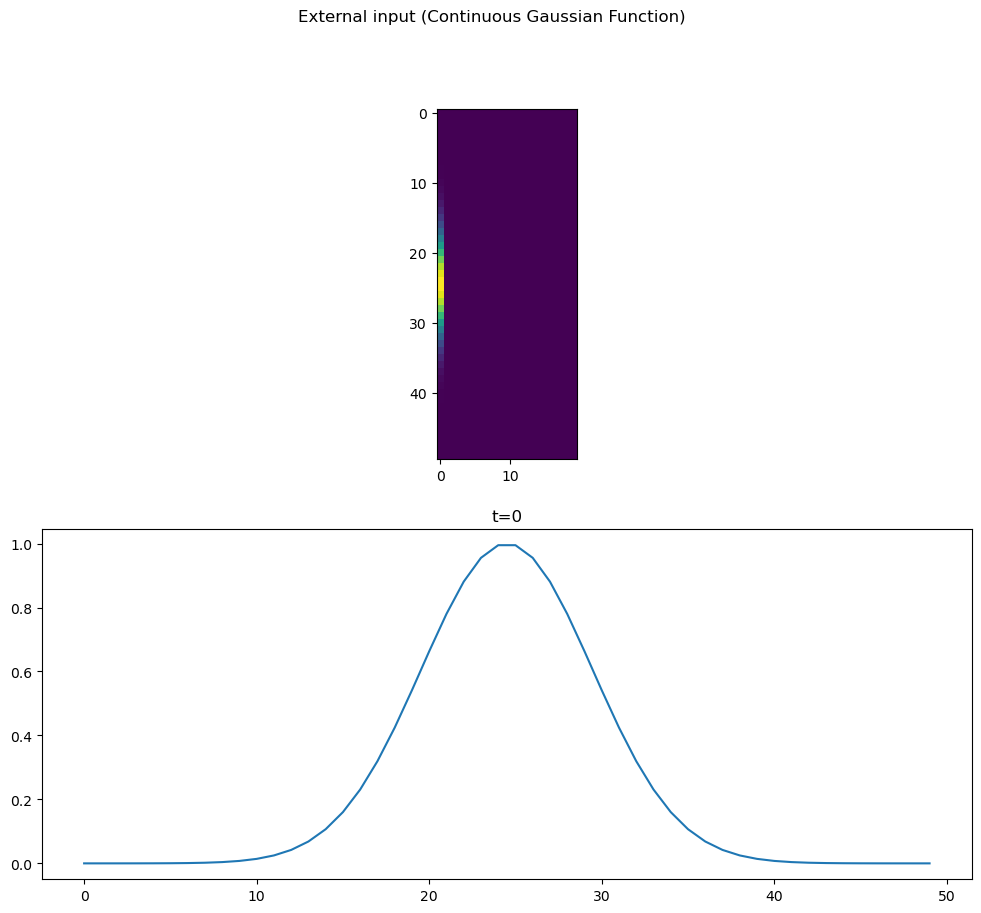

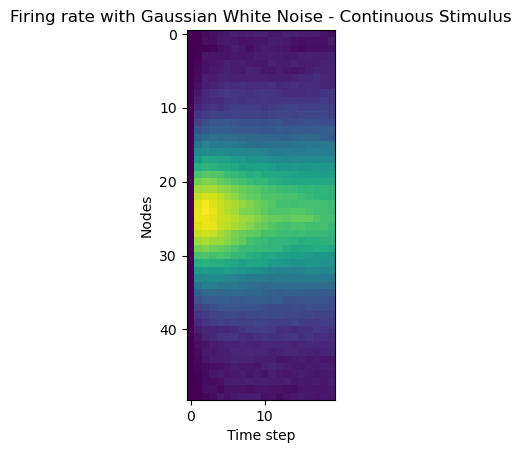

In [236]:
network_strong_r = ndyn.Network(N=50, T=20, L=np.pi, diff_matrix_func=diff_matrix_for_periodic_stimulus, W_kwargs={'a': np.pi/2})
network_strong_r.W = 5 * ndyn.gaussian_func(ndyn.get_diff_matrix(network_strong_r), a=np.pi/2)
ndyn.plot_weight(network_strong_r, 25, 'Gaussian Kernel with Strong Recurrent Weights')

L = network_strong_r.L
gaussian_kernel = ndyn.gaussian_func(np.linspace(-L, L, network_strong_r.N), a=np.pi/2)
I_gf_t0 = np.zeros((network_strong_r.N, network_strong_r.T))
I_gf_t0[:, 0] = gaussian_kernel.T
# I_gf_t0[25] = 1 * np.ones(network_strong_r.T)
ndyn.plot_external_input_at_t(I_gf_t0, 0, 'External input (Continuous Gaussian Function)')
solution = network_strong_r.simulate(I_gf_t0, euler_ivp_gwn, lambda sol: sol, ivp_func_kwargs={'tau': 3, 'rho': 10, 'k': 0.001})
ndyn.plot_firing_rate(network_strong_r, 'Firing rate with Gaussian White Noise - Continuous Stimulus')